In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns

# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler
ray.init(log_to_driver=False)

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

_TARGET_STK = 'MSFT'
pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False

2024-01-19 21:23:18,239	INFO worker.py:1724 -- Started a local Ray instance.


In [2]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = [_TARGET_STK, 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['VIXCLS', 'SP500', 'DJIA']

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)
# stk_data = web.get_data_yahoo(stk_tickers, start, end)
stk_data = yfin.download(stk_tickers, start, end).dropna()
ccy_data = web.DataReader(ccy_tickers, 'fred', start, end).dropna()
idx_data = web.DataReader(idx_tickers, 'fred', start, end).dropna()

print(stk_data)
print(ccy_data)
print(idx_data)

[*********************100%%**********************]  3 of 3 completed
             Adj Close                               Close                                High                                 Low                                Open                             Volume                   
                 GOOGL         IBM        MSFT       GOOGL         IBM        MSFT       GOOGL         IBM        MSFT       GOOGL         IBM        MSFT       GOOGL         IBM        MSFT      GOOGL      IBM      MSFT
Date                                                                                                                                                                                                                        
2014-01-02   27.855856  116.571327   31.290825   27.855856  177.370941   37.160000   27.971722  179.158707   37.400002   27.734234  177.055450   37.099998   27.914413  178.977051   37.349998   72783144  4755639  30632200
2014-01-03   27.652653  117.268761   31.080299 

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation_size = 0.2
epoch_num = 300
batch_size = 32
log_dir = f'/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}'

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class LSTMDataSet(Dataset):
    def __init__(self, X, Y, seq_len, features):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
        self.features = features
    def __len__(self):
        return len(self.X) - self.seq_len + 1
    
    def __getitem__(self, idx):
        return (torch.tensor(np.array(self.X[idx: idx + self.seq_len].loc[:, self.features]), dtype=torch.float32),
                torch.tensor(np.array(self.Y.iloc[idx + self.seq_len - 1,:]), dtype=torch.float32))


In [ ]:
from torch import nn
class StockPricePredictionLSTM(nn.Module):
    def __init__(self, seq_len, input_size, hidden_size, num_layers, num_fc_layers, activation_type):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if (out_features <= 1):
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU() if activation_type == 1 else
                          nn.Sigmoid()) if activation_type == 2 else nn.Tanh()
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)
            # print(f"{m.in_features},{m.out_features}")

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


In [6]:
import math 
from sklearn.metrics import mean_squared_error

def eval_dl_method(model, dl, criterion=None, device=device):
    model.eval()
    y_gt = []
    y_pred = []
    vloss = 0.0
    for i, (x, y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        if criterion != None:
            vloss += criterion(outputs, y).item()
        # print(f"{i}:{vloss}")
        y_gt.extend(y.cpu().detach().numpy().reshape(-1))
        y_pred.extend(outputs.cpu().detach().numpy().reshape(-1))
    
    return (math.sqrt(mean_squared_error(y_gt, y_pred)), y_gt, y_pred, vloss)

In [7]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper


def gen_analysis_data(stock_name, return_period):
    import pandas_ta
    data = stk_data.xs(stock_name, axis=1, level=1)
    
    data = pd.concat([data.ta.percent_return(length=return_period, prefix=stock_name),
                      data.ta.adosc(prefix=stock_name),
                      data.ta.kvo(prefix=stock_name)], 
                      axis=1)
    data = data.dropna().astype('float32')
    return data

def prepare_dataloader(return_period, seq_len):
    Target_Data = gen_analysis_data(_TARGET_STK, return_period)
    GOOGL_Data = gen_analysis_data('GOOGL', return_period)
    IBM_Data = gen_analysis_data('IBM', return_period)

    X1 = pd.concat([Target_Data, GOOGL_Data, IBM_Data], axis=1)

    X2 = ccy_data.pct_change(return_period).dropna()
    X2 = X2.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X2.columns.to_list()})

    X3 = pd.concat([idx_data['SP500'].pct_change(return_period), idx_data['DJIA'].pct_change(return_period)], axis=1)
    X3 = X3.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X3.columns.to_list()})
    X3 = pd.concat([idx_data['VIXCLS'], X3], axis=1).dropna()

    X1_X2_X3 = pd.concat([X1, X2, X3], axis=1).dropna()
    features = X1_X2_X3.columns.to_list()

    Y_raw = stk_data.loc[:, ('Adj Close', _TARGET_STK)].to_frame().pct_change(return_period).shift(-return_period).dropna().astype('float32')
    Y_raw.columns = [f"{_TARGET_STK}_pred_{return_period}"]

    dataset = pd.concat([Y_raw, X1_X2_X3], axis=1).dropna()

    X = dataset.loc[:, X1_X2_X3.columns]
    Y = dataset.loc[:, Y_raw.columns]

    train_size = int(len(X) * (1 - validation_size))
    X_train = X.iloc[0:train_size].loc[:,features]
    Y_train = Y.iloc[0:train_size]
    X_test  = X.iloc[train_size - seq_len + 1:len(X)].loc[:, features]
    Y_test  = Y.iloc[train_size - seq_len + 1:len(Y)]

    X_dfm = DataFrameMapper(
        [ ([column], StandardScaler()) for column in X_train.columns.to_list()]
        , input_df=True, df_out=True)
    X_train = X_dfm.fit_transform(X_train)
    X_test = X_dfm.transform(X_test)

    train_loader = DataLoader(LSTMDataSet(X_train, Y_train, seq_len, features), batch_size=batch_size)
    test_loader = DataLoader(LSTMDataSet(X_test, Y_test, seq_len,features), batch_size=batch_size)

    return train_loader, test_loader, features

In [17]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore')

def do_train(model, optimizer, train_dl, test_dl, id_str, writer):
    criterion = torch.nn.MSELoss()

    model_name = f"{log_dir}/{id_str}.pt"
    best_loss = 999999999    
    total_loss = 0.0
    total_vloss = 0.0
    for epoch in tqdm(range(epoch_num)):
        model.train()
        running_loss = 0.0
        
        for i, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), model_name)

        with torch.no_grad():
            (testScore, test_y_gt, test_y_pred, running_vloss)  = eval_dl_method(model, test_dl, criterion)
            train.report({"mse_score":testScore})
            
        writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : running_loss / len(train_dl), 'Validation' : running_vloss / len(test_dl) },
                            epoch + 1)
        total_loss += running_loss / len(train_dl)
        total_vloss += running_vloss / len(test_dl)

        writer.flush()
        
    return {'Train loss':total_loss/epoch_num, 'Validation loss': total_vloss/epoch_num}

def train_LSTM(config):
    return_period = 5 #config["return_period"]
    seq_len = 5 #config["seq_len"]
    lr = 0.01 #config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    num_fc_layers = config["num_fc_layers"]
    activation_type = config["activation_type"]

    id_str = f"{return_period}_{seq_len}_{lr}_{momentum}_{optim_type}_{num_layers}_{hidden_size}_{num_fc_layers}_{activation_type}"

    writer = SummaryWriter(f"{log_dir}/{id_str}")    

    train_loader, test_loader, features = prepare_dataloader(return_period, seq_len)
    model = StockPricePredictionLSTM(seq_len, input_size=len(features),
                                     hidden_size=hidden_size,num_layers=num_layers,
                                     num_fc_layers=num_fc_layers, activation_type=activation_type)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) if optim_type == 1 else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    metric_dict = do_train(model, optimizer, train_loader, test_loader, id_str, writer)
    writer.add_hparams(
        {
            "return_period": return_period,
            "seq_len": seq_len,
            "lr": lr,
            "momentum": momentum,
            "optim_type": optim_type,
            "num_layers": num_layers,
            "hidden_size": hidden_size,
            "num_fc_layers": num_fc_layers,
            "activation_type": activation_type
        },
        metric_dict
    )
    writer.close()


In [ ]:
time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}'
config={
    "return_period":2,
    "seq_len":2,
    "lr":0.1,
    "momentum":0.4100411732392869,
    "optim_type":2,
    "num_layers":1,
    "hidden_size":128,
    "num_fc_layers":2,
    "activation_type":1
}
train_LSTM(config)

In [18]:
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', module='TF-TRT')
warnings.filterwarnings('ignore', module='tensorflow')
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=SyntaxWarning)
warnings.filterwarnings('ignore', category=PendingDeprecationWarning)
warnings.filterwarnings('ignore', category=ImportWarning)
warnings.filterwarnings('ignore', category=UnicodeWarning)
warnings.filterwarnings('ignore', category=BytesWarning)
warnings.filterwarnings('ignore', category=ResourceWarning)
warnings.simplefilter("always")


search_space = {
    # "return_period": tune.grid_search([2,3,5,10]),
    # "seq_len": tune.grid_search([2,3,4,5]),
    # "lr": tune.grid_search([0.001, 0.01, 0.1]),
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([1, 2]),
    "num_layers": tune.grid_search([1, 2, 4, 8]),
    "hidden_size": tune.grid_search([8, 16, 32, 64, 128]),
    "num_fc_layers": tune.grid_search([1, 2, 3]),
    "activation_type": tune.grid_search([1, 2, 3])
}

time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}'

analysis = tune.run(train_LSTM, 
                    config=search_space,
                    resources_per_trial={'cpu':0.1, 'gpu':0.1},
                    metric="mse_score",
                    mode="min")

2024-01-19 21:52:54,351	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-19 21:52:54,363	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,mse_score
train_LSTM_278d2_00000,0.0499599
train_LSTM_278d2_00001,0.0564039
train_LSTM_278d2_00002,0.0480619
train_LSTM_278d2_00003,0.0607098
train_LSTM_278d2_00004,0.0620129
train_LSTM_278d2_00005,0.0699729
train_LSTM_278d2_00006,0.0564917
train_LSTM_278d2_00007,0.0603667
train_LSTM_278d2_00008,0.0601814
train_LSTM_278d2_00009,0.0545767


2024-01-20 01:00:07,849	INFO tune.py:1042 -- Total run time: 11233.50 seconds (11233.44 seconds for the tuning loop).


In [19]:
mse_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    if trial.empty == False:
        d = pd.DataFrame.from_dict({"mse_score": trial.describe().loc['mean', 'mse_score'], "trial_id": trial.loc[0:0,'trial_id'] })
    else:
        d = pd.DataFrame.from_dict({"mse_score": [np.NaN], "trial_id": [np.NaN]})
    mse_list.append(d)
mse_df = pd.concat(mse_list)
mse_df = mse_df.reset_index().loc[:, ["mse_score", "trial_id"]]
print(mse_df)


     mse_score     trial_id
0     0.047597  278d2_00000
1     0.051936  278d2_00001
2     0.053743  278d2_00002
3     0.052701  278d2_00003
4     0.053960  278d2_00004
..         ...          ...
355   0.039063  278d2_00355
356   0.039645  278d2_00356
357   0.046811  278d2_00357
358   0.039301  278d2_00358
359   0.059767  278d2_00359

[360 rows x 2 columns]


In [29]:
config_df = pd.DataFrame(analysis.get_all_configs().values())
print(config_df)

results = pd.concat([mse_df, config_df], axis=1)
print(results)

sorted_results = results.sort_values(by="mse_score")
print(sorted_results.head(100))
sorted_results_file = f"{time_str}_sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]]
print(best_config)

     momentum  optim_type  num_layers  hidden_size  num_fc_layers  activation_type
0     0.49678           1           1            8              1                1
1     0.69578           1           1            8              1                2
2     0.71175           1           1            8              1                3
3     0.58273           1           1           16              1                1
4     0.48747           1           1           16              1                2
..        ...         ...         ...          ...            ...              ...
355   0.49438           2           8           64              3                2
356   0.49899           2           8           64              3                3
357   0.21838           2           8          128              3                1
358   0.70031           2           8          128              3                2
359   0.15960           2           8          128              3                3

[36

In [31]:
id_str_of_best = f"5_5_0.01_{best_config.momentum}_{int(best_config.optim_type)}_{int(best_config.num_layers)}_{int(best_config.hidden_size)}_{int(best_config.num_fc_layers)}_{int(best_config.activation_type)}"
best_model_name = f"{log_dir}/{id_str_of_best}.pt"
print(best_model_name)

/mnt/AIWorkSpace/work/fin-ml/runs/MSFT/2024-01-19_21.52.54/5_5_0.01_0.15544857677627022_2_2_128_1_1.pt


In [33]:
sorted_results = pd.read_csv(sorted_results_file, dtype='str')
best_config = sorted_results.loc[0]

id_str_of_best = f"5_5_0.01_{best_config.momentum}_{best_config.optim_type}_{best_config.num_layers}_{best_config.hidden_size}_{best_config.num_fc_layers}_{best_config.activation_type}"
best_model_name = f"/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}/{id_str_of_best}.pt"
print(best_model_name)

/mnt/AIWorkSpace/work/fin-ml/runs/MSFT/2024-01-19_21.52.54/5_5_0.01_0.15544857677627022_2_2_128_1_1.pt


In [34]:
import math 
from sklearn.metrics import mean_squared_error

pd.set_option('display.precision', 5)

return_period = 5
seq_len = 5
train_loader, test_loader, features = prepare_dataloader(return_period, seq_len)

model = StockPricePredictionLSTM(seq_len, input_size=len(features),
                                     hidden_size=int(best_config.hidden_size),num_layers=int(best_config.num_layers),
                                     num_fc_layers=int(best_config.num_fc_layers), activation_type=int(best_config.activation_type))

model.load_state_dict(torch.load(best_model_name))
model.to(device)
model.eval()

(trainScore, train_y_gt, train_y_pred, _)= eval_dl_method(model, train_loader, device=device)
(testScore, test_y_gt, test_y_pred, _)  = eval_dl_method(model, test_loader, device=device)
print(test_y_pred)
print(f"Train RMSE: {trainScore:.2f}\nTest RMSE: {testScore:.2f}")


[-0.01913168, -0.019504327, -0.011383627, -0.0018858279, 0.0065648886, 0.013105243, 0.0154249035, 0.0142230205, 0.009373609, 0.016051397, 0.015376259, 0.019547615, 0.021208778, 0.018554017, 0.014335179, 0.0066048815, 0.0017346644, -0.0019805694, 0.0017169917, 0.0046631186, 0.008506959, 0.008576211, 0.0076857167, 0.00676595, 0.005709655, 0.007099658, 0.0070419717, 0.01186125, 0.010594994, -0.0015245436, -0.01708326, -0.019816663, -0.02356705, -0.014966112, -0.0031675848, 0.010282513, 0.017187852, 0.015281171, 0.014310181, 0.0072756666, 0.0021835712, -0.003127877, -0.0011100324, -0.00039109617, -0.0007595721, -0.0015480036, -0.0010318349, -0.00012999616, -0.000624711, 0.0007201654, 0.00023460732, -0.0006976056, -0.0031614641, 0.0009568517, 0.0018576344, 0.0050204205, 0.0057956944, 0.004854675, -0.0008689764, -0.002084032, -0.002251888, 0.00074620143, -0.0012283886, -0.0025973732, -0.0042590615, -0.011051614, -0.014402155, -0.012495797, -0.0075592515, -0.0022902715, 0.016931176, 0.0232491

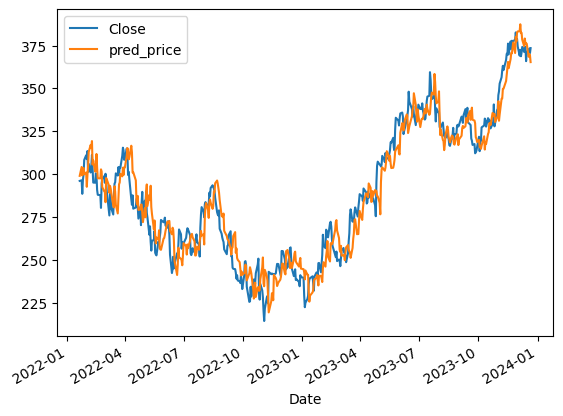

In [35]:
target_raw = stk_data.loc[test_loader.dataset.X.index.values].xs(_TARGET_STK, axis=1, level=1)
# print(target_raw)
target_raw = target_raw.drop(target_raw.index[range(seq_len - 1)], axis=0)

test_y_pred_df = pd.DataFrame(index=target_raw.index.copy())
test_y_pred_df['pred_price'] = test_y_pred
test_y_pred_df['pred_price'] = (test_y_pred_df['pred_price'] + 1) * target_raw['Close']
test_y_pred_df = test_y_pred_df.shift(return_period)
tmp_data = pd.concat([target_raw, test_y_pred_df], axis=1).dropna()

tmp_data['Close'].plot()
tmp_data['pred_price'].plot()
pyplot.legend()
pyplot.show()
